Autoencoders

4 tipos de autoencoders con el MNIST dataset

1. Vanilla autoencoders
2. Multilayer autoencoder
3. Convolutional autoencoder
4. Regularized autoencoder

## Librerias

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import to_categorical

## Dataset

No necesitamos las etiquetas porque no vamos a clasificar

In [2]:
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

## Normalizamos

In [3]:
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Flatten para las redes de capas densas

In [4]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

___

# **Vanilla Autoencoder**

### Creamos la red

Tres capas: Input - encoded - decoded

In [5]:
input_size = 784
hidden_size = 64
output_size = 784

In [6]:
x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu')(x)
r = Dense(output_size, activation='sigmoid')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 784)            │        50,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,200 (395.31 KB)

 Trainable params: 101,200 (395.31 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenar

In [7]:
epochs = 5
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0742 - val_loss: 0.0225
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0197 - val_loss: 0.0128
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0119 - val_loss: 0.0087
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0083 - val_loss: 0.0066
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0065 - val_loss: 0.0056


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step


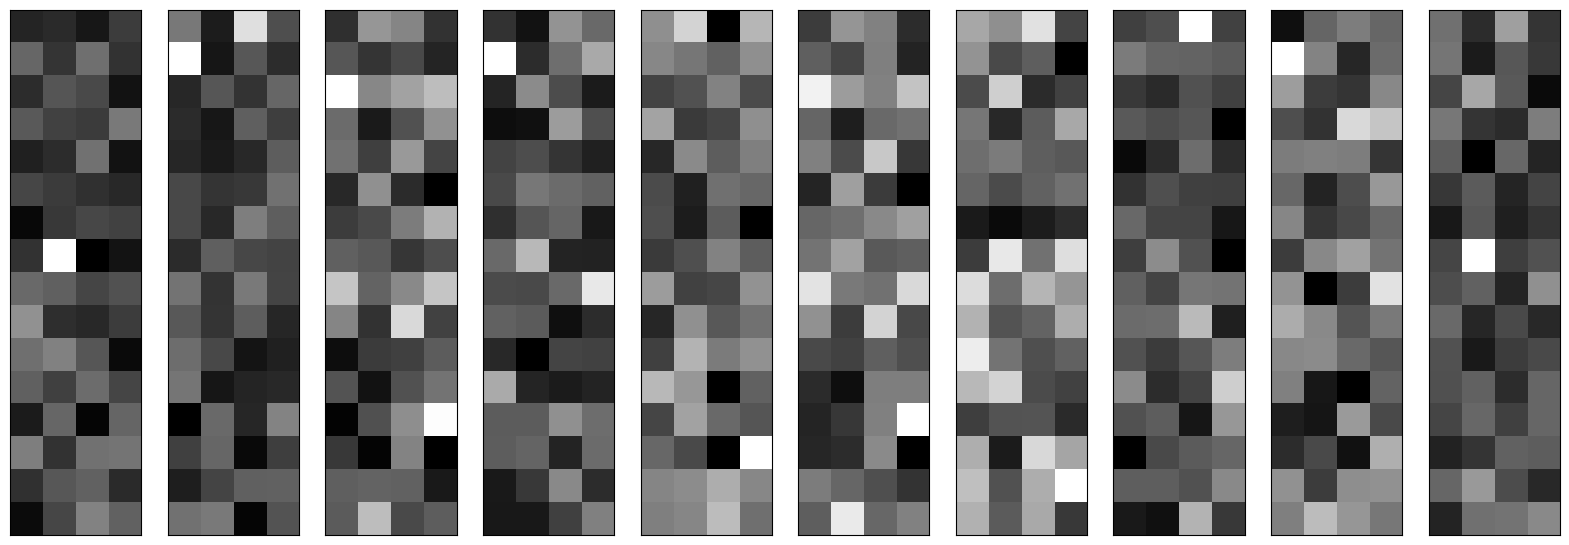

In [8]:
conv_encoder = Model(x, h)
encoded_imgs = conv_encoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 16).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Predicción

In [9]:
decoded_imgs = autoencoder.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


### Plot

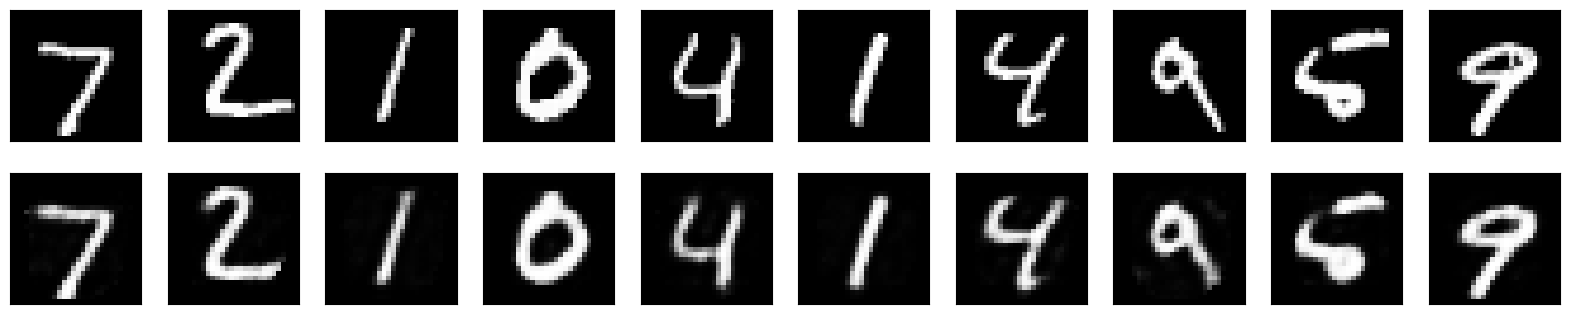

In [10]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Plot the losses

dict_keys(['loss', 'val_loss'])


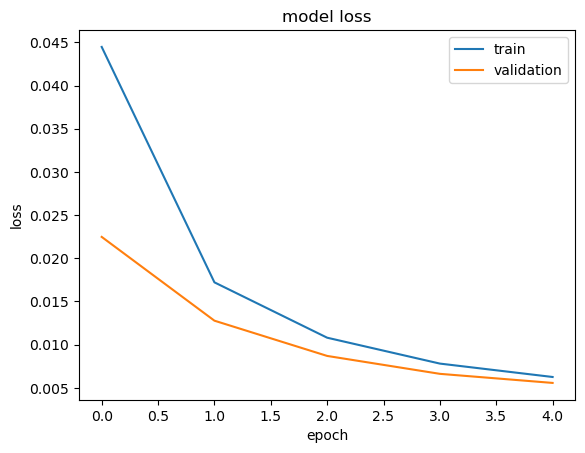

In [11]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

---

# **Multilayer autoencoder**

### Create the network

We extend the idea of the first network to more layers

In [12]:
input_size = 784
hidden_size = 128
code_size = 64

x = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(x)
h = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(h)
r = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

### Train the network

In [13]:
epochs = 5
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0681 - val_loss: 0.0191
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0175 - val_loss: 0.0129
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0124 - val_loss: 0.0101
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0101 - val_loss: 0.0088
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0089 - val_loss: 0.0082


### Predict on the test set

In [14]:
decoded_imgs = autoencoder.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


### Plot

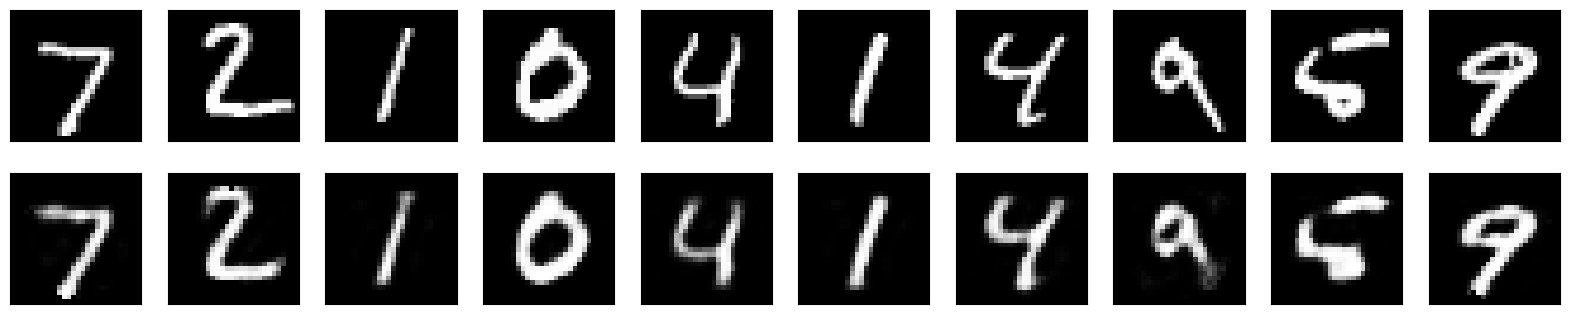

In [15]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Plot the losses

dict_keys(['loss', 'val_loss'])


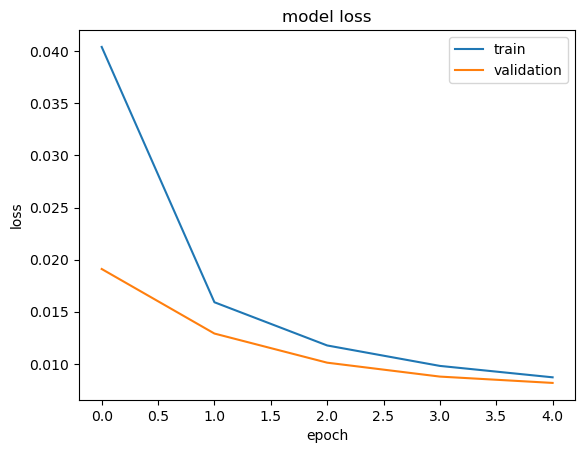

In [16]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

___

# **Convolutional autoencoder**

In [17]:
nb_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### Create the network

This network does not take flattened vectors as an input but images

In [18]:
x = Input(shape=(28, 28,1)) 

# Encoder
conv1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv1_2)
conv1_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
h = MaxPooling2D((2, 2), padding='same')(conv1_3)


# Decoder
conv2_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
conv2_3 = Conv2D(16, (3, 3), activation='relu')(up2)
up3 = UpSampling2D((2, 2))(conv2_3)
r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

### Train

In [19]:
epochs = 3
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 0.6944 - val_loss: 0.6922
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.6913 - val_loss: 0.6882
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 0.6868 - val_loss: 0.6816


In [20]:
decoded_imgs = autoencoder.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


### Plot

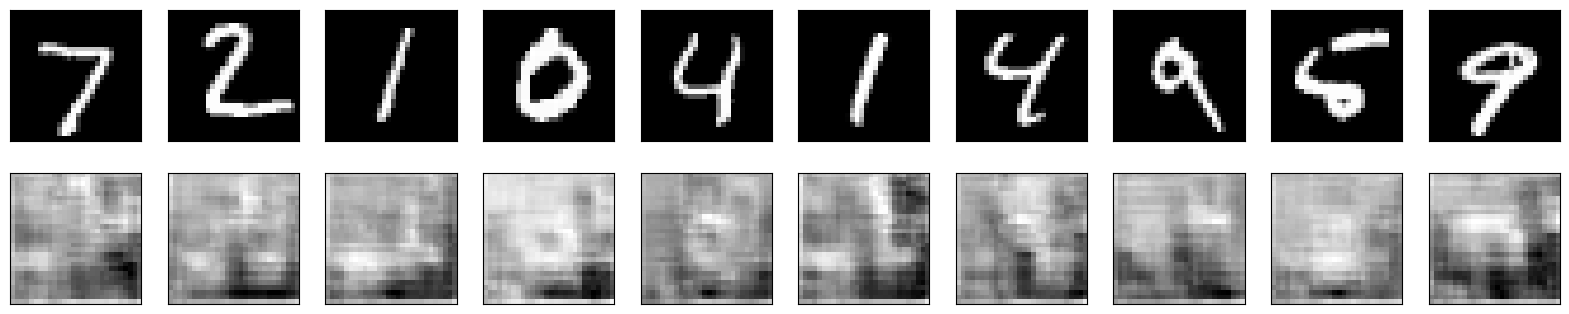

In [21]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Plot the losses

dict_keys(['loss', 'val_loss'])


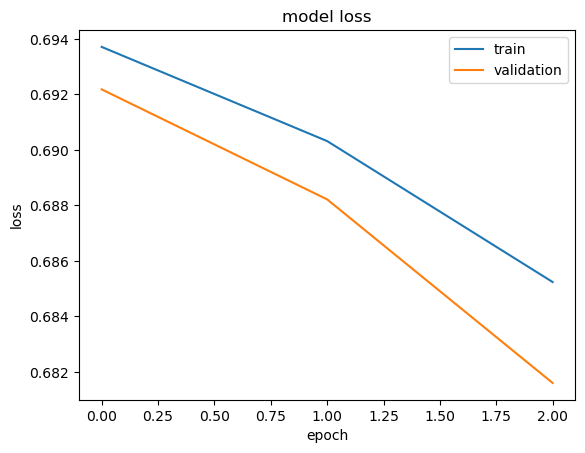

In [22]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

___

# **Regularized autoencoder**

Two types of regularization are described : 
- Sparse autoencoder
- Denoising autoencoder

## 1. Sparse autoencoder

### Create the network

In [23]:
input_size = 784
hidden_size = 32
output_size = 784

In [24]:
x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu', activity_regularizer=regularizers.l1(10e-5))(x)
r = Dense(output_size, activation='sigmoid')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

In [25]:
epochs = 15
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

RuntimeError: Unable to automatically build the model. Please build it yourself before calling fit/evaluate/predict. A model is 'built' when its variables have been created and its `self.built` attribute is True. Usually, calling the model on a batch of data is the right way to build it.
Exception encountered:
'Input 0 of layer "functional_4" is incompatible with the layer: expected shape=(None, 784), found shape=(128, 28, 28)'

### Predict on the test set

In [ ]:
decoded_imgs = autoencoder.predict(X_test)

### Plot

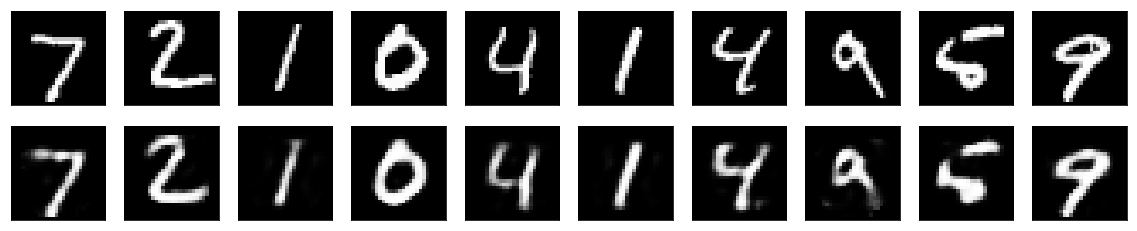

In [ ]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Plot the losses

dict_keys(['loss', 'val_loss'])


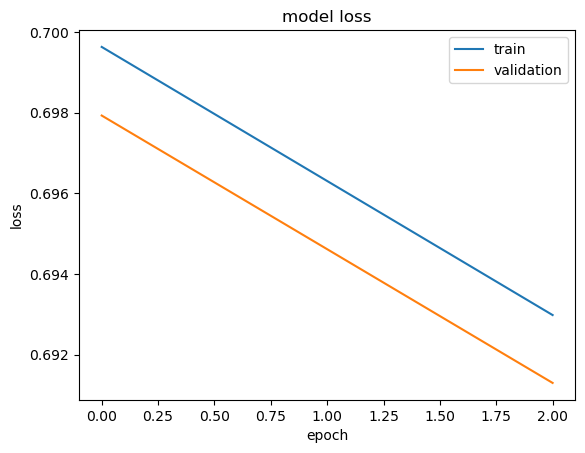

In [ ]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## 2. Denoising autoencoder

In [26]:
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

### Create noisy data

In [27]:
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

### Create the network

In [28]:
x = Input(shape=(28, 28, 1))

# Encoder
conv1_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
conv1_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
h = MaxPooling2D((2, 2), padding='same')(conv1_2)


# Decoder
conv2_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

### Train the network

In [33]:
epochs = 10
batch_size = 128

history = autoencoder.fit(X_train_noisy, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test_noisy, X_test))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - loss: 0.5182 - val_loss: 0.5065
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - loss: 0.5011 - val_loss: 0.4979
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 71ms/step - loss: 0.4922 - val_loss: 0.4894
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - loss: 0.4841 - val_loss: 0.4801
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - loss: 0.4743 - val_loss: 0.4696
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 61ms/step - loss: 0.4632 - val_loss: 0.4575
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - loss: 0.4509 - val_loss: 0.4429
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - loss: 0.4356 - val_loss: 0.4244
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - loss: 0.4166 - val_loss: 0.4011
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - loss: 0.3923 - val_loss: 0.3725


In [34]:
decoded_imgs = autoencoder.predict(X_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


### Plot

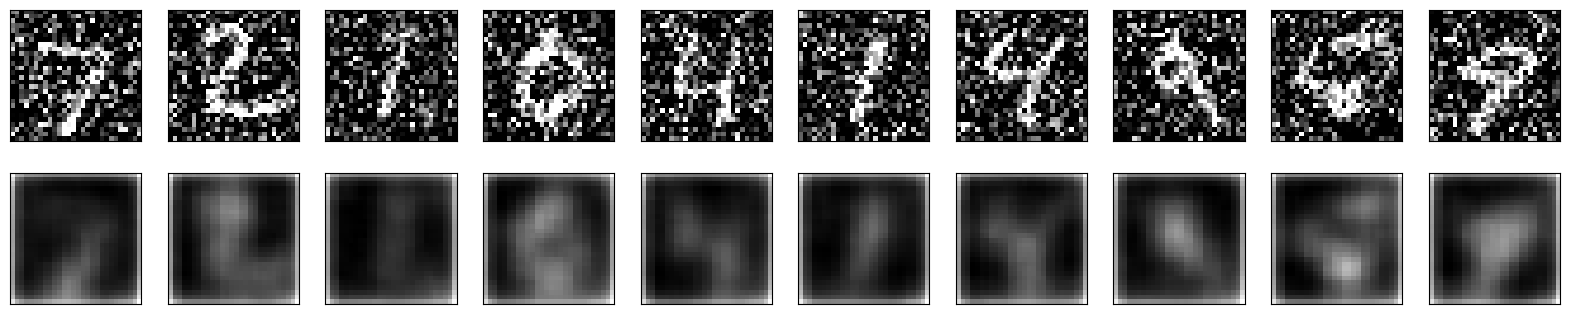

In [35]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Plot the losses

dict_keys(['loss', 'val_loss'])


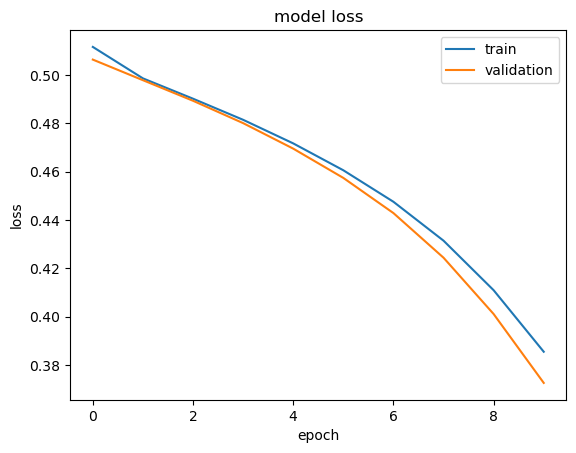

In [36]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

___

---